In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc as pm
import arviz as az
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

#### IMPORT DATA ####

In [2]:
# Create the foundational dataset
df_ = pd.read_csv('cpi_fah_eda_dataset.csv')
df_['date'] = pd.to_datetime(df_['date'], format='%Y-%m-%d')
df_ = df_.reset_index().set_index('date').drop(columns = 'index')

# This is the forecast df that gets updated each month
df_fcst = pd.read_csv('cpi_fah_forecast_month.csv')
df_fcst = df_fcst.set_index('month')


In [3]:
df_

,grocery_sales,cpi_fah,restaurant_sales,oil_prices,ppi_farm_products,ppi_food_mfg,ppi_grocery,wages_retail,grocery_units,covid1,...,wages_retail_yoy_lag3,wages_retail_yoy_lag4,wages_retail_yoy_lag5,wages_retail_yoy_lag6,wages_retail_yoy_lag7,wages_retail_yoy_lag8,wages_retail_yoy_lag9,wages_retail_yoy_lag10,wages_retail_yoy_lag11,wages_retail_yoy_lag12
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,36402.0,183.300,24839.0,34.310000,117.400,139.300,121.300,NaN,198.592471,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,35890.0,183.700,24952.0,34.684737,120.400,140.400,125.700,NaN,195.372891,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,36365.0,184.100,27054.0,36.741304,129.100,142.400,125.200,NaN,197.528517,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,36312.0,184.300,26738.0,36.750000,129.600,146.100,123.100,NaN,197.026587,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,36528.0,186.600,27839.0,40.275000,135.100,149.100,122.200,NaN,195.755627,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,75998.0,309.754,86965.0,70.118095,233.953,262.051,276.134,24.86,245.349535,0,...,2.117940,2.292622,2.130326,2.260360,2.732240,2.099076,2.743774,2.524190,2.931181,3.371746
2025-01-01,76071.0,311.178,80656.0,75.742500,239.580,262.949,291.471,24.97,244.461369,0,...,2.955870,2.117940,2.292622,2.130326,2.260360,2.732240,2.099076,2.743774,2.524190,2.931181
2025-02-01,76383.0,311.203,NaN,71.533158,255.073,266.500,293.162,25.01,245.444292,0,...,3.572912,2.955870,2.117940,2.292622,2.130326,2.260360,2.732240,2.099076,2.743774,2.524190


#### COMMAND CENTRAL ####

In [4]:
# Set the beginning and end dates

start_date = '2009-01-01'
end_date = '2025-03-01'
df = df_[(df_.index >= start_date) & (df_.index <= end_date)].copy()

# MODEL VARIABLES
vars_yoy = ['cpi_fah_yoy', 'oil_prices_yoy', 'ppi_farm_products_yoy', 'ppi_food_mfg_yoy', 'ppi_grocery_yoy', 'grocery_units_yoy']
ind = ['oil_prices_yoy_lag6', 'ppi_farm_products_yoy_lag2', 'ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'grocery_units_yoy']
dep = 'cpi_fah_yoy'
dep_label = "CPI Food-at-Home"
ind_label_0 = 'oil_prices_yoy_lag6' 
ind_label_1 = 'ppi_farm_products_yoy_lag2'
ind_label_2 = 'ppi_food_mfg_yoy_lag5'
ind_label_3 = 'ppi_grocery_yoy_lag1'
ind_label_4 = 'grocery_units_yoy'


#Independent forward forecast estimates
ind_label_0_dic = {pd.Timestamp('2025-04-01'): 8, pd.Timestamp('2025-05-01'): -6, pd.Timestamp('2025-06-01'): -21, pd.Timestamp('2025-07-01'): -16,
                      pd.Timestamp('2025-08-01'): -10, pd.Timestamp('2025-09-01'): -2}

ind_label_1_dic = {pd.Timestamp('2025-04-01'): 12.88, pd.Timestamp('2025-05-01'): 16.18, pd.Timestamp('2025-06-01'): 7.69, pd.Timestamp('2025-07-01'): 7,
                             pd.Timestamp('2025-08-01'): 6.5, pd.Timestamp('2025-09-01'): 6.0}

ind_label_2_dic = {pd.Timestamp('2025-04-01'): 3.7, pd.Timestamp('2025-05-01'): 3.3, pd.Timestamp('2025-06-01'): 4.4, pd.Timestamp('2025-07-01'): 5.2,
                   pd.Timestamp('2025-08-01'): 4.5, pd.Timestamp('2025-09-01'): 4.5}

ind_label_3_dic = {pd.Timestamp('2025-04-01'): 2.2, pd.Timestamp('2025-05-01'): 2.2, pd.Timestamp('2025-06-01'): 2.2, pd.Timestamp('2025-07-01'): 2.2, 
                       pd.Timestamp('2025-08-01'): 2.2, pd.Timestamp('2025-09-01'): 2.2}

ind_label_4_dic = {pd.Timestamp('2025-04-01'): 1.8, pd.Timestamp('2025-05-01'): 1.7, pd.Timestamp('2025-06-01'): 1.6, pd.Timestamp('2025-07-01'): 1.5,
                            pd.Timestamp('2025-08-01'): 1.5, pd.Timestamp('2025-09-01'): 1.5}



In [5]:
for col in df.columns:
    print(col)

grocery_sales
cpi_fah
restaurant_sales
oil_prices
ppi_farm_products
ppi_food_mfg
ppi_grocery
wages_retail
grocery_units
covid1
covid2
grocery_sales_diff
cpi_fah_diff
restaurant_sales_diff
oil_prices_diff
ppi_farm_products_diff
ppi_food_mfg_diff
ppi_grocery_diff
wages_retail_diff
grocery_units_diff
grocery_sales_yoy
cpi_fah_yoy
restaurant_sales_yoy
oil_prices_yoy
ppi_farm_products_yoy
ppi_food_mfg_yoy
ppi_grocery_yoy
wages_retail_yoy
grocery_units_yoy
cpi_fah_yoy_lag1
cpi_fah_yoy_lag2
cpi_fah_yoy_lag3
cpi_fah_yoy_lag4
cpi_fah_yoy_lag5
cpi_fah_yoy_lag6
cpi_fah_yoy_lag7
cpi_fah_yoy_lag8
cpi_fah_yoy_lag9
cpi_fah_yoy_lag10
cpi_fah_yoy_lag11
cpi_fah_yoy_lag12
oil_prices_yoy_lag1
oil_prices_yoy_lag2
oil_prices_yoy_lag3
oil_prices_yoy_lag4
oil_prices_yoy_lag5
oil_prices_yoy_lag6
oil_prices_yoy_lag7
oil_prices_yoy_lag8
oil_prices_yoy_lag9
oil_prices_yoy_lag10
oil_prices_yoy_lag11
oil_prices_yoy_lag12
ppi_farm_products_yoy_lag1
ppi_farm_products_yoy_lag2
ppi_farm_products_yoy_lag3
ppi_farm_produ

#### CHECK FOR MISSING VALUES ####

In [6]:
# Nothing kills a regression faster than missing data

# Count total missing values per column
missing_counts = df[ind].isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

grocery_units_yoy    1
dtype: int64

In [7]:
# Step 1: Identify which model variables (in X) have missing values
missing_vars = df[ind].columns[df[ind].isna().any()].tolist()

# Step 2: Forward-fill only those variables, in-place
df.loc[:, missing_vars] = df[missing_vars].ffill()


In [8]:
# Nothing kills a regression faster than missing data

# Count total missing values per column
missing_counts = df[ind].isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

#### CPI FAH MODEL VS PPI MEASURES ####

In [9]:
X = df[ind]
y = df[dep]

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df.loc[:, f'{dep}_pred'] = model.fittedvalues
df.loc[:, f'{dep}_resid'] = model.resid

                            OLS Regression Results                            
Dep. Variable:            cpi_fah_yoy   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     223.2
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           2.84e-77
Time:                        21:39:17   Log-Likelihood:                -319.37
No. Observations:                 195   AIC:                             650.7
Df Residuals:                     189   BIC:                             670.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### VISUALS AND DIAGNOSTICS ####

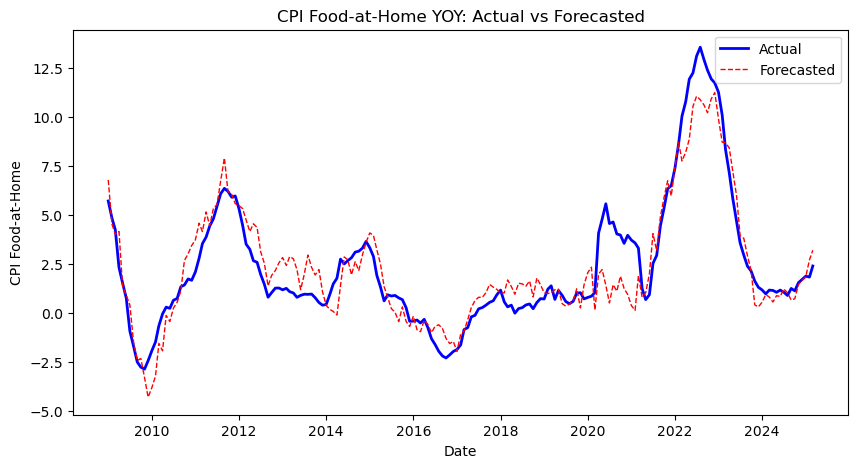

In [10]:
df_plot = df.copy()
df_plot['date'] = df_plot.index

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x='date', y=dep, label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df_plot, x='date', y=f'{dep}_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel(dep_label)
plt.title(f'{dep_label} YOY: Actual vs Forecasted')
plt.legend()
plt.show()

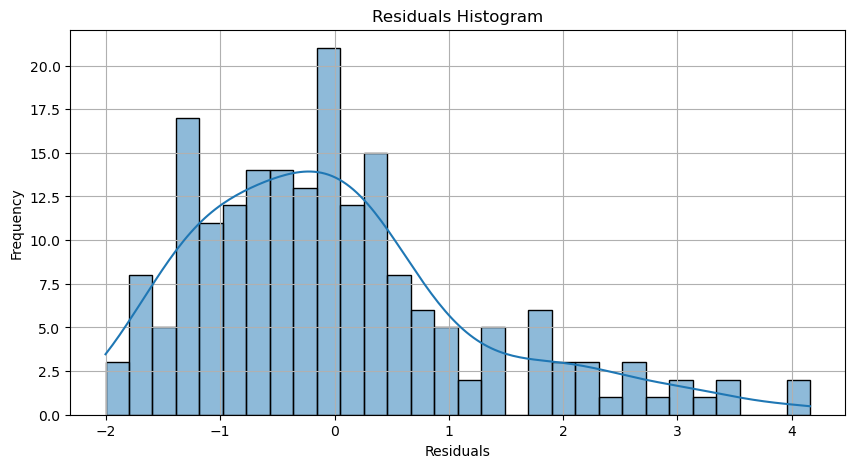

In [11]:
resid_data = df[f"{dep}_resid"].reset_index(drop=True)
plt.figure(figsize=(10, 5))
sns.histplot(resid_data, bins=30, kde=True)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

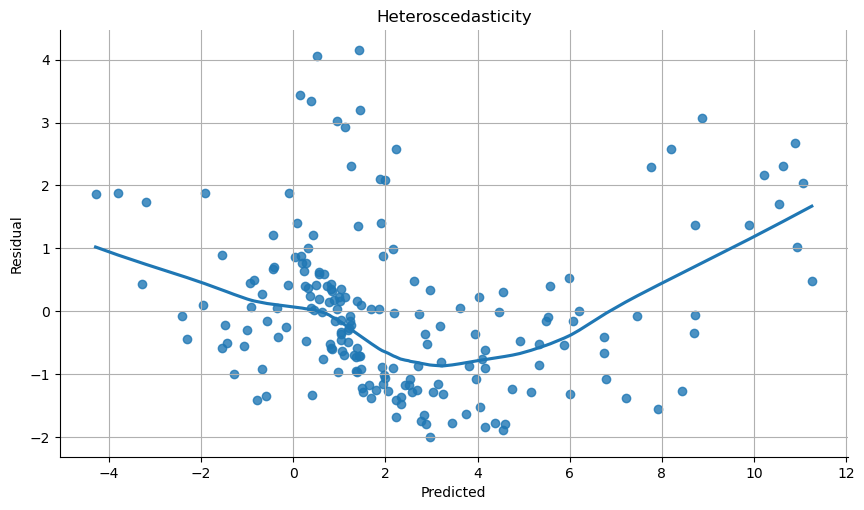

In [12]:
resid_data = df[f"{dep}_resid"].reset_index(drop=True)
# Reset both predicted and residual Series
pred_data = df[f"{dep}_pred"].reset_index(drop=True)
resid_data = df[f"{dep}_resid"].reset_index(drop=True)

# Combine into a clean DataFrame
df_plot = pd.DataFrame({
    f"{dep}_pred": pred_data,
    f"{dep}_resid": resid_data
})

sns.lmplot(
    x=f"{dep}_pred", y=f"{dep}_resid",
    data=df_plot, lowess=True, aspect=1.75, height=5
)
plt.title('Heteroscedasticity')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [13]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,2.741620
1,oil_prices_yoy_lag6,1.757126
2,ppi_farm_products_yoy_lag2,1.805397
3,ppi_food_mfg_yoy_lag5,2.970776
4,ppi_grocery_yoy_lag1,1.719079
5,grocery_units_yoy,1.369830


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [14]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals
df[f'{dep}_se_mean'] = pred_summary['mean_se']  # SE of the mean
df[f'{dep}_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df[f'{dep}_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df[f'{dep}_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[[f'{dep}_se_mean', f'{dep}_se_mean', f'{dep}_se_obs', f'{dep}_se_lower', f'{dep}_se_upper', 
    'lower_bound', 'upper_bound']].head()

,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_obs,cpi_fah_yoy_se_lower,cpi_fah_yoy_se_upper,lower_bound,upper_bound
date,,,,,,,
2009-01-01,0.324283,0.324283,1.313550,6.155400,7.434757,4.220521,9.369637
2009-02-01,0.391531,0.391531,1.331980,3.770798,5.315461,1.932448,7.153810
2009-03-01,0.337269,0.337269,1.316858,3.359988,4.690576,1.444240,6.606324
2009-04-01,0.273164,0.273164,1.301721,3.629257,4.706939,1.616724,6.719472
2009-05-01,0.293083,0.293083,1.306102,0.803282,1.959550,-1.178545,3.941376


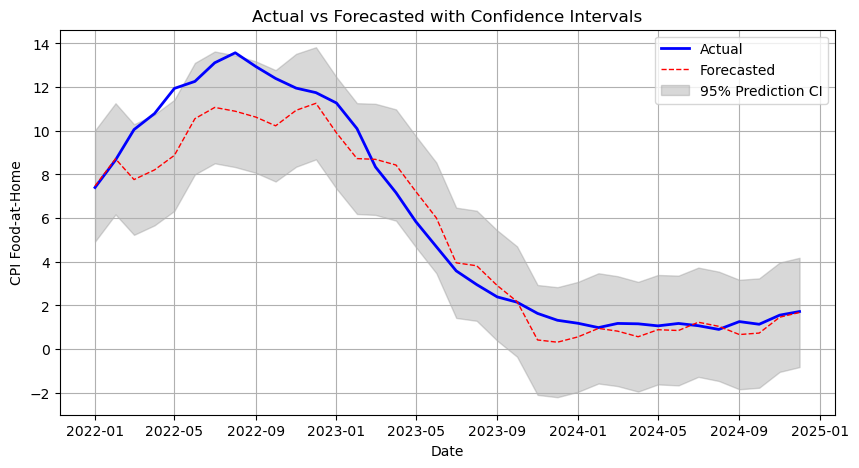

In [15]:
#Define the start and end date for filtering
start_date = '2022-01-01'
end_date = '2024-12-31'

#Filter the DataFrame to only include the desired months
df_subset = df.loc[start_date:end_date]
df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_subset, x=df_subset.index, y=df_subset[dep], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_subset, x=df_subset.index, y=f'{dep}_pred', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_subset.index, df_subset['lower_bound'], df_subset['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel(f'{dep_label}')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### VALIDATE THE MODEL ####

In [16]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()
df_validate.index = pd.to_datetime(df_validate.index)  # If it's not already datetime

results = []

# Define unique months in the index
all_months = df_validate.index.to_period('M').unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.to_period('M').isin(train_months)]
    test_df = df_validate[df_validate.index.to_period('M').isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[ind]
    y_train = train_df[dep]

    X_test = test_df[ind]
    y_test = test_df[dep]
    
    # ✅ Fit model and predict
    cpi_validate = LinearRegression()
    cpi_validate.fit(X_train, y_train)
    forecast = cpi_validate.predict(X_test)

    mae = mean_absolute_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0].strftime('%Y-%m'),
        'test_end': test_months[-1].strftime('%Y-%m'),
        'MAE': mae,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


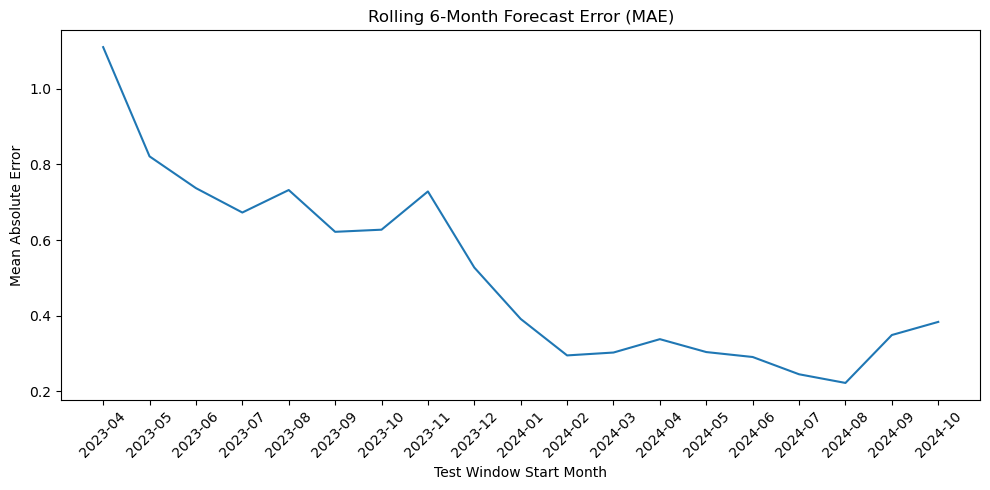

In [17]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAE'])

# Now plot
plt.figure(figsize=(10, 5))
plt.plot(plot_data['test_start'], plot_data['MAE'])
plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()

#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [18]:
df[f'{dep}_se_obs']

date
2009-01-01    1.313550
2009-02-01    1.331980
2009-03-01    1.316858
2009-04-01    1.301721
2009-05-01    1.306102
                ...   
2024-11-01    1.277728
2024-12-01    1.277094
2025-01-01    1.276424
2025-02-01    1.279085
2025-03-01    1.286167
Name: cpi_fah_yoy_se_obs, Length: 195, dtype: float64

In [19]:
df.index.dtype

dtype('<M8[ns]')

#### BUILD THE FORWARD FILE AND PREP FOR CONCAT ####

In [20]:
# Define the forward forecast period and build the file

start = pd.Timestamp("2025-04-01")
end = pd.Timestamp("2025-09-01")

# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range(start, end, freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
    prev_year = date - pd.DateOffset(years=1)  

    forward_df.loc[date, ind[0]] = ind_label_0_dic[date]
    forward_df.loc[date, ind[1]] = ind_label_1_dic[date]
    forward_df.loc[date, ind[2]] = ind_label_2_dic[date]
    forward_df.loc[date, ind[3]] = ind_label_3_dic[date]
    forward_df.loc[date, ind[4]] = ind_label_4_dic[date]

# Add empty columns for forecast and intervals
forward_df[dep] = np.nan
forward_df[f"{dep}_pred"] = np.nan

# Pull the 6 months of SE values from one year ago
se_obs_values = df[f'{dep}_se_obs'].iloc[-12:-6].copy()  

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df.loc[se_obs_values.index, f'{dep}_se_obs'] = se_obs_values

forward_df

,oil_prices_yoy_lag6,ppi_farm_products_yoy_lag2,ppi_food_mfg_yoy_lag5,ppi_grocery_yoy_lag1,grocery_units_yoy,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs
2025-04-01,8.0,12.88,3.7,2.2,1.8,NaN,NaN,1.282017
2025-05-01,-6.0,16.18,3.3,2.2,1.7,NaN,NaN,1.278849
2025-06-01,-21.0,7.69,4.4,2.2,1.6,NaN,NaN,1.282820
2025-07-01,-16.0,7.00,5.2,2.2,1.5,NaN,NaN,1.276713
2025-08-01,-10.0,6.50,4.5,2.2,1.5,NaN,NaN,1.277541
2025-09-01,-2.0,6.00,4.5,2.2,1.5,NaN,NaN,1.279264


In [21]:
for col in forward_df.columns:
    print(col)

oil_prices_yoy_lag6
ppi_farm_products_yoy_lag2
ppi_food_mfg_yoy_lag5
ppi_grocery_yoy_lag1
grocery_units_yoy
cpi_fah_yoy
cpi_fah_yoy_pred
cpi_fah_yoy_se_obs


#### GET THE COEF FOR THE FORWARD FCST ####

In [22]:
# Convert model coefficients to a dictionary
coef_dict = model.params.to_dict()

# Print or use
for var, coef in coef_dict.items():
    print(f"{var}: {coef:.4f}")


const: 0.3302
oil_prices_yoy_lag6: 0.0060
ppi_farm_products_yoy_lag2: 0.0580
ppi_food_mfg_yoy_lag5: 0.2846
ppi_grocery_yoy_lag1: 0.2696
grocery_units_yoy: -0.0758


In [23]:
const = coef_dict['const']
ind_label_0 = coef_dict[ind[0]]
ind_label_1 = coef_dict[ind[1]]
ind_label_2 = coef_dict[ind[2]]
ind_label_3 = coef_dict[ind[3]]
ind_label_4 = coef_dict[ind[4]]

#print 
print(ind_label_0)
print(ind_label_1)
print(ind_label_2)
print(ind_label_3)
print(ind_label_4)

0.006001698892296415
0.05804300205912365
0.2846099384755611
0.26964272363457453
-0.07580924877130689


#### MAKE THE FORWARD FCST ####

In [24]:
# Start with intercept
const = coef_dict['const']

# Initialize lists for forecast and confidence intervals
forecasted = []
lower_ci = []
upper_ci = []

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    # Begin with intercept
    y_hat = const
    
    # Add all independent variables dynamically
    for var in ind:
        y_hat += coef_dict[var] * row[var]
    
    # Store forecast
    forecasted.append(round(y_hat, 2))
    
    # Get standard error for observation-level prediction
    se_obs = row[f"{dep}_se_obs"]
    
    # 95% confidence interval
    lower_ci.append(y_hat - 1.96 * se_obs)
    upper_ci.append(y_hat + 1.96 * se_obs)

# Assign results back to the DataFrame
forward_df[f'{dep}_pred'] = forecasted
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci

#### CONCAT THE FORWARD DF AND DF ####

In [25]:
# Stack the df and forward df
df_subset = df[forward_df.columns]
df_full = pd.concat([df_subset, forward_df], axis=0)
df_full.tail(12)

,oil_prices_yoy_lag6,ppi_farm_products_yoy_lag2,ppi_food_mfg_yoy_lag5,ppi_grocery_yoy_lag1,grocery_units_yoy,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs,lower_bound,upper_bound
2024-10-01,7.427603,-1.744943,1.291654,0.756637,1.474888,1.136562,0.733311,1.278205,-1.771970,3.238592
2024-11-01,11.800193,0.354709,2.212094,1.678139,0.580579,1.554147,1.459664,1.277728,-1.044683,3.964010
2024-12-01,13.550934,1.735200,2.805668,1.839778,1.698910,1.719773,1.678041,1.277094,-0.825064,4.181146
2025-01-01,7.533840,6.102522,2.221742,2.354873,1.865908,1.884939,1.855461,1.276424,-0.646330,4.357251
2025-02-01,-5.778512,9.864942,2.322754,5.061854,2.374823,1.840107,2.714032,1.279085,0.207026,5.221039
2025-03-01,-21.458205,12.883239,2.101041,6.832792,2.374823,2.405630,3.209538,1.286167,0.688651,5.730424
2025-04-01,8.000000,12.880000,3.700000,2.200000,1.800000,NaN,2.640000,1.282017,0.122854,5.148360
2025-05-01,-6.000000,16.180000,3.300000,2.200000,1.700000,NaN,2.640000,1.278849,0.130317,5.143406
2025-06-01,-21.000000,7.690000,4.400000,2.200000,1.600000,NaN,2.370000,1.282820,-0.139624,4.889030
2025-07-01,-16.000000,7.000000,5.200000,2.200000,1.500000,NaN,2.600000,1.276713,0.097573,5.102289


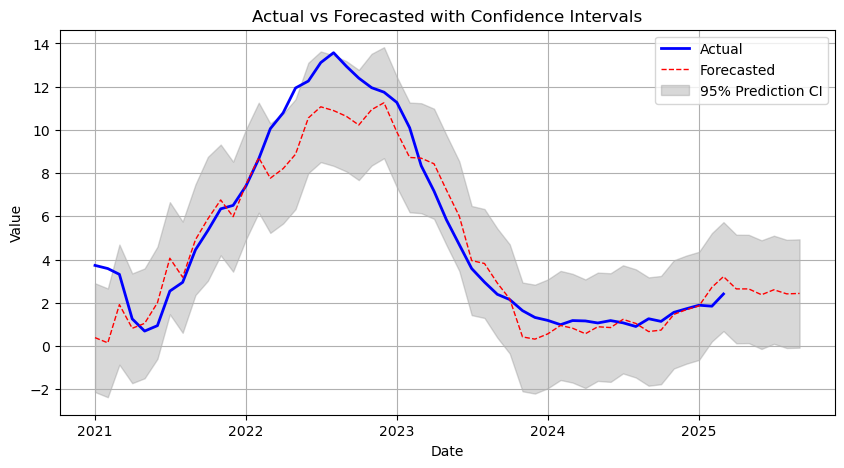

In [26]:
#Define the start and end date for filtering
start_date = '2021-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_chart = df_full.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=dep, label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=f'{dep}_pred', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [27]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 2009-01-01 to 2025-09-01
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   oil_prices_yoy_lag6         201 non-null    float64
 1   ppi_farm_products_yoy_lag2  201 non-null    float64
 2   ppi_food_mfg_yoy_lag5       201 non-null    float64
 3   ppi_grocery_yoy_lag1        201 non-null    float64
 4   grocery_units_yoy           201 non-null    float64
 5   cpi_fah_yoy                 195 non-null    float64
 6   cpi_fah_yoy_pred            201 non-null    float64
 7   cpi_fah_yoy_se_obs          201 non-null    float64
 8   lower_bound                 201 non-null    float64
 9   upper_bound                 201 non-null    float64
dtypes: float64(10)
memory usage: 25.4 KB


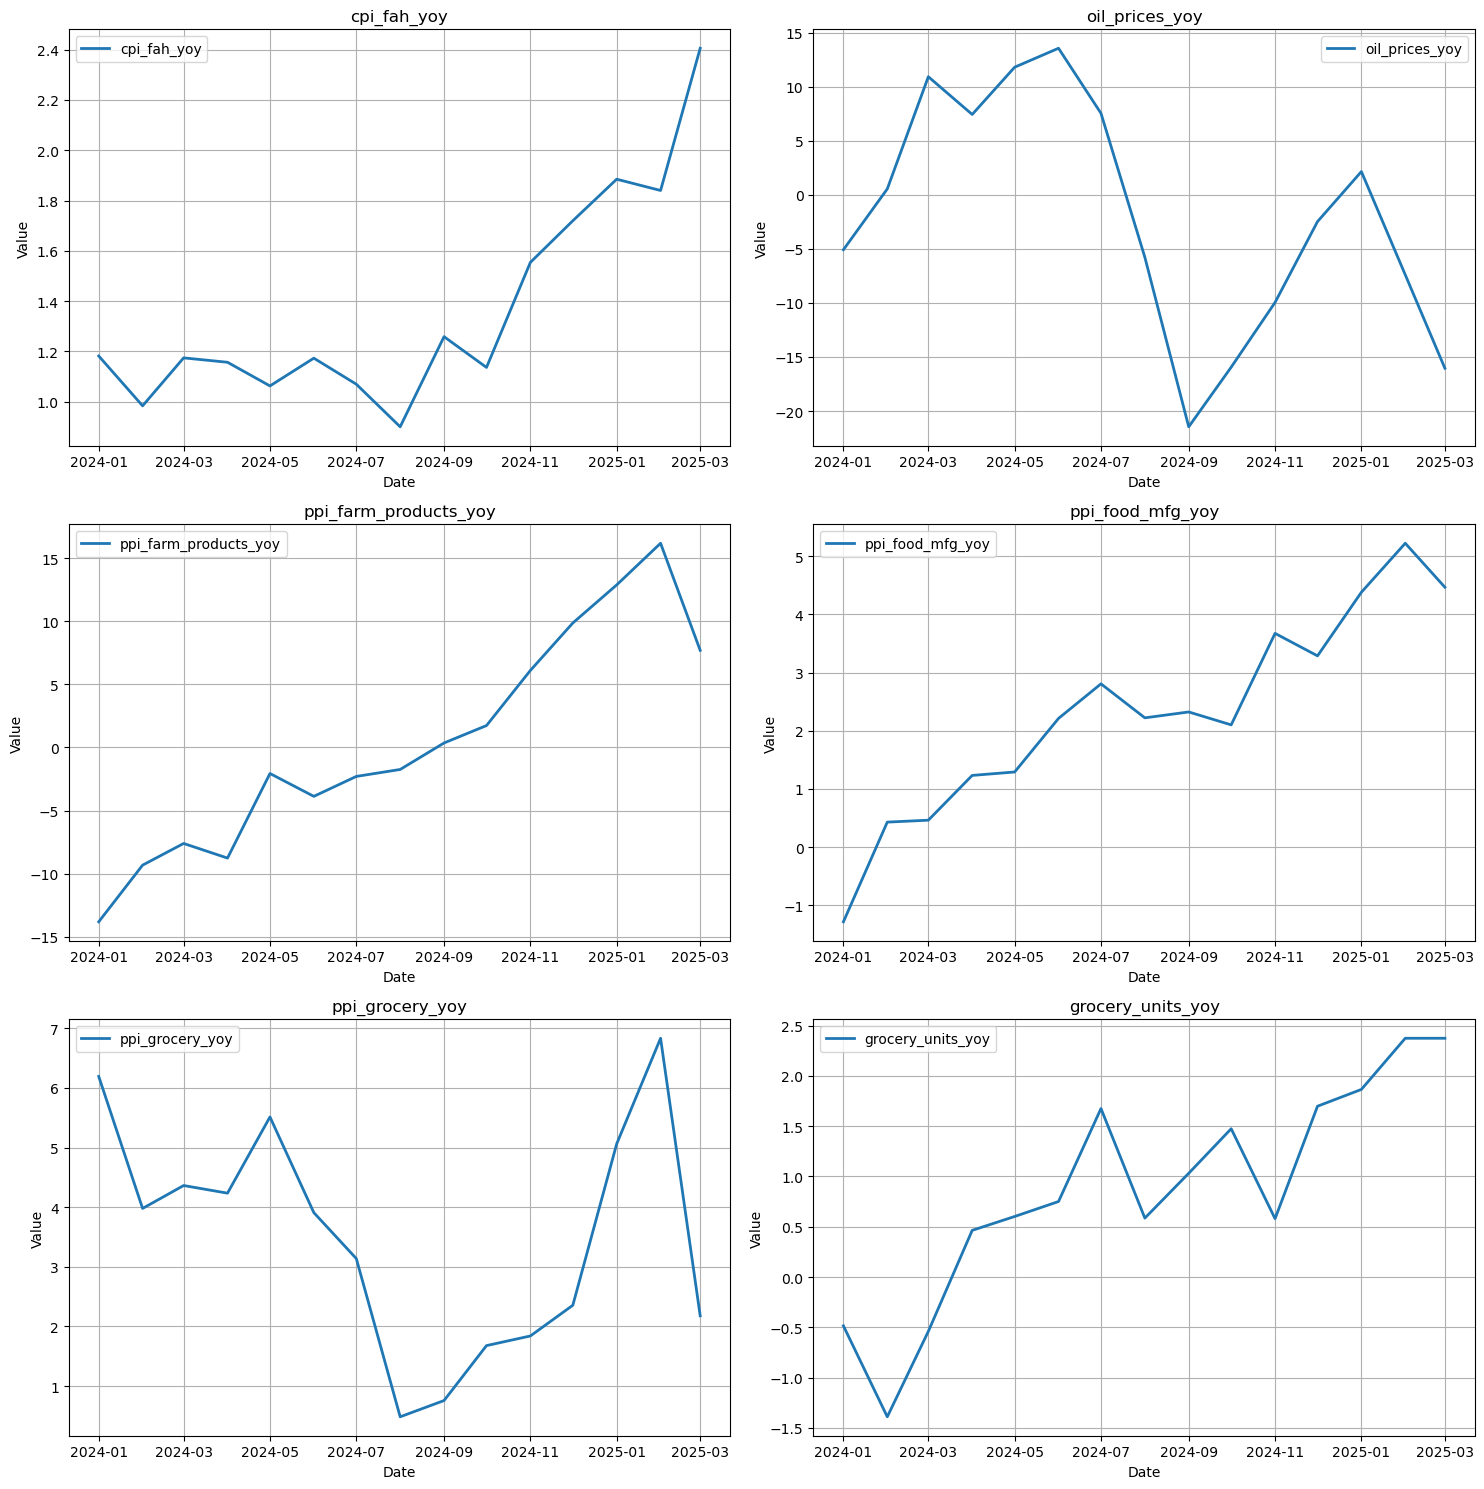

In [28]:
#Define the start and end date for filtering
start_date = '2024-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_input_charts = df.loc[start_date:end_date]

# Create a grid of subplots (2 columns × enough rows for all variables)
num_vars = len(vars_yoy)
rows = (num_vars // 2) + (num_vars % 2)  # Ensures enough rows for all variables

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, 5 * rows))  # Dynamically sized

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each variable and plot
for i, col in enumerate(vars_yoy):
    ax = axes[i]  # Select the subplot
    ax.plot(df_input_charts.index, df_input_charts[col], label=col, linewidth=2)
    
    # Customize the subplot
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    ax.grid(True)
    ax.legend()

# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()

#### BUILD THE FORECAST DF ####

In [29]:
# Build a df to hold the forecasts
# Define the forward forecast period and build the file

# start = pd.Timestamp("2025-04-01")
# end = pd.Timestamp("2025-09-01")

# # Build the df based on the date range.  The months become the index
# forecast_months = pd.date_range(start, end, freq="MS")
# df_fcst = pd.DataFrame(index=forecast_months)

# df_fcst_values = df_full['cpi_fah_yoy_pred']

# df_fcst_values = df_fcst_values[df_fcst_values.index >= start]

# df_fcst = pd.merge(df_fcst, df_fcst_values, right_index=True, left_index=True, how='left')

# df_fcst

In [30]:
df_fcst

,P-2025-02,P-2025-04,Actuals
month,,,
2/1/2025,1.1,NaN,1.8
3/1/2025,1.8,NaN,2.4
4/1/2025,1.9,1.9,NaN
5/1/2025,2.5,2.4,NaN
6/1/2025,2.9,2.7,NaN
7/1/2025,3.1,2.7,NaN
8/1/2025,NaN,3.0,NaN
9/1/2025,NaN,2.5,NaN


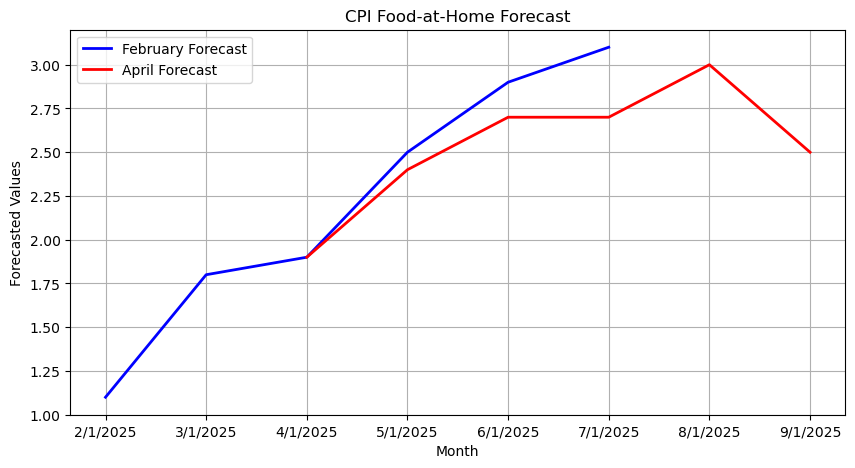

In [31]:
#Define the start and end date for filtering
#start_date = '2021-01-01'
#end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
#df_chart = df_fcst.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['P-2025-02'], label='February Forecast', color='blue', linewidth=2.0)
sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['P-2025-04'], label='April Forecast', color='red', linewidth=2.0)
#sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['Actuals'], label='Actual Values', color='black', linewidth=2.0)

plt.xlabel('Month')
plt.ylabel('Forecasted Values')
plt.title('CPI Food-at-Home Forecast')
plt.legend()
plt.grid(True)

plt.show()

In [32]:
df_fcst.to_csv('cpi_fah_forecast_month.csv')

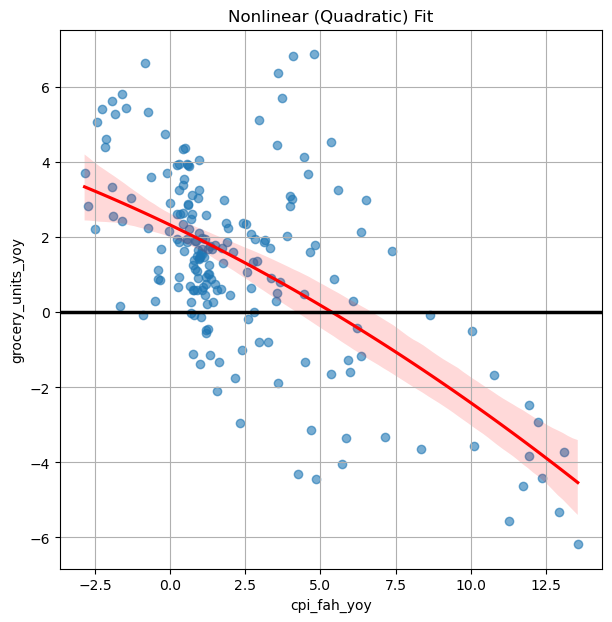

In [33]:
df_filtered = df[(df['grocery_units_yoy'] > -10) & (df['grocery_units_yoy'] < 10)]

#Plot the chart
plt.figure(figsize=(7, 7))

# Nonlinear fit using order=2 (quadratic)
sns.regplot(data=df_filtered, x='cpi_fah_yoy', y='grocery_units_yoy', order=2, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.axhline(y=0, color='black', linewidth=2.5)  # ← customize here
plt.title("Nonlinear (Quadratic) Fit")
plt.grid(True)
plt.show()

#### BAYESIAN ANALYSIS ####

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 29 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.333,0.150,0.034,0.609,0.003,0.002,2986.0,3036.0,1.0
coefs[0],0.006,0.003,0.000,0.011,0.000,0.000,3371.0,2558.0,1.0
coefs[1],0.058,0.009,0.041,0.075,0.000,0.000,3603.0,3105.0,1.0
coefs[2],0.285,0.033,0.222,0.350,0.001,0.001,2828.0,2416.0,1.0
coefs[3],0.269,0.027,0.213,0.321,0.000,0.000,3029.0,2944.0,1.0
coefs[4],-0.076,0.032,-0.137,-0.013,0.001,0.000,3065.0,3000.0,1.0
sigma,1.274,0.064,1.153,1.399,0.001,0.001,3746.0,2806.0,1.0


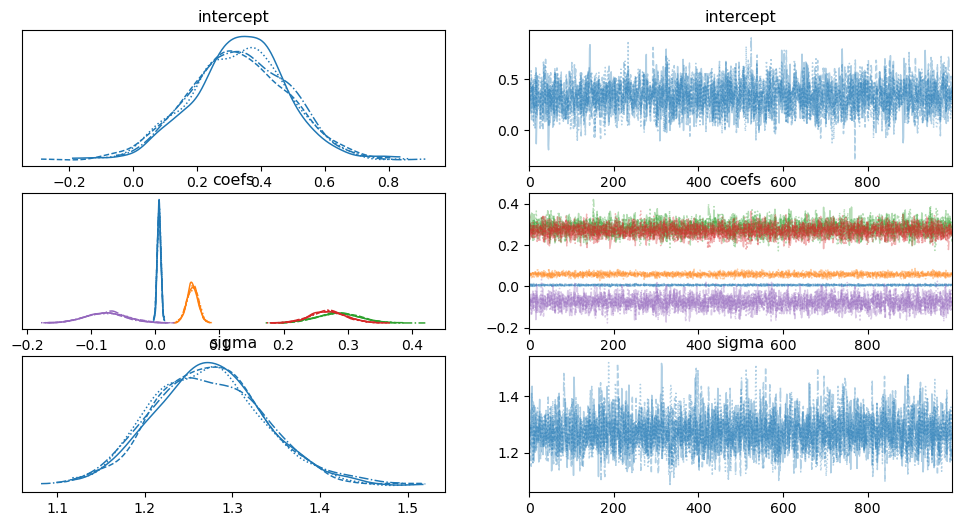

In [34]:
# Within Sample Model

# Extract X and y
X = df[ind]
y = df[dep]

X_data = X.to_numpy()
y_data = y.to_numpy()
n, k = X_data.shape

with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefs = pm.Normal("coefs", mu=0, sigma=10, shape=k)
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Expected value
    mu = intercept + pm.math.dot(X_data, coefs)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    # Sampling
    trace = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True)

# Diagnostics
az.plot_trace(trace)
az.summary(trace, hdi_prob=0.95)


In [35]:
# List of forecast months
forecast_months = list(ind_label_0_dic.keys())

# Create DataFrame for predictors in the same order as training
X_future_df = pd.DataFrame({
    'oil_prices_yoy_lag6': [ind_label_0_dic[date] for date in forecast_months],
    'ppi_farm_products_yoy_lag2': [ind_label_1_dic[date] for date in forecast_months],
    'ppi_food_mfg_yoy_lag5': [ind_label_2_dic[date] for date in forecast_months],
    'ppi_grocery_yoy_lag1': [ind_label_3_dic[date] for date in forecast_months],
    'grocery_units_yoy': [ind_label_4_dic[date] for date in forecast_months]

}, index=forecast_months)

# Convert to numpy for prediction
X_future = X_future_df.to_numpy()

In [36]:
print(ind_label_0)

0.006001698892296415


In [37]:
print("coefs_samples shape:", coefs_samples.shape)
print("intercept_samples shape:", intercept_samples.shape)
print("X_future shape:", X_future.shape)
print("X_future[0] shape:", X_future[0].shape)


NameError: name 'coefs_samples' is not defined

In [ ]:
# Transpose coefficients to shape (8000, 5)
coefs_samples = coefs_samples.T

posterior_preds = []

for i in range(X_future.shape[0]):
    x_row = X_future[i]  # shape (5,)
    preds = intercept_samples + coefs_samples @ x_row  # shape: (8000,)
    posterior_preds.append(preds)

In [ ]:
# Convert list of arrays to DataFrame
pred_df = pd.DataFrame({str(month.date()): preds for month, preds in zip(forecast_months, posterior_preds)})

# Compute probability of exceeding 4%
prob_over_3 = (pred_df >= 3).mean()

print("📊 Probability CPI FAH ≥ 3% by Month")
print(prob_over_3.round(2))


In [ ]:
import matplotlib.pyplot as plt

pred_df.plot(kind='kde', title="Posterior Predictive Distributions")
plt.axvline(x=3, color='red', linestyle='--', label='3% threshold')
plt.legend()
plt.xlabel("CPI Food-at-Home YoY")
plt.show()
